In [1]:
import pandas as pd
import os

In [1]:
import sys
import os
sys.path.append(os.path.join(".."))

from module.trend_analysis_functions import *

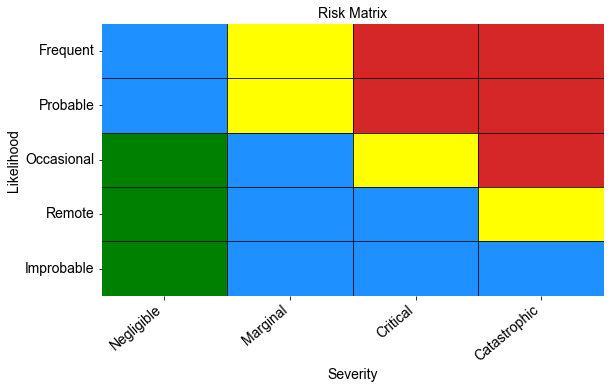

In [5]:
plt.rcParams["font.family"] = "arial"

plot_USFS_risk_matrix({}, {}, figsize=(9,5), save=False, results_path=os.path.join(os.path.dirname(os.getcwd()),'results','risk_matrices', 'blank_rm'), fontsize=14, max_chars=20, title=True)

In [2]:
def get_ICS_severity_FAA(severity_table, hazards):
    severities = {hazard:[] for hazard in hazards}
    #severity table -> index
    for hazard in hazards:
        #temp_df = severity_table.loc[severity_table["Hazard"]==hazard.replace("_", " ")].reset_index(drop=True)
        severities[hazard].append(round(severity_table.at[hazard,"Average Injuries"]) - severity_table.at[hazard, "Total Avg Injuries"])
        severities[hazard].append(severity_table.at[hazard,"Average Structures Damaged"] - severity_table.at[hazard,"Total Avg Str Dam"])
        severities[hazard].append(severity_table.at[hazard,"Average Structures Destroyed"] - severity_table.at[hazard,"Total Avg Str Des"])
        severities[hazard].append(round(severity_table.at[hazard,"Average Fatalities"]) - severity_table.at[hazard, "Total Avg Fatalities"])
    severity_df = pd.DataFrame(severities, 
                            index=['Diff_Injuries', 'Diff_Structures_Damages', 
                                     'Diff_Structures_Destroyed','Diff_Fatalities'])

    total_severities = []
    curr_severities = {}
    for hazard in hazards: 
        injuries = severity_df.at['Diff_Injuries',hazard]
        str_dam = severity_df.at['Diff_Structures_Damages', hazard]
        str_des = severity_df.at['Diff_Structures_Destroyed', hazard]
        fatalities = severity_df.at['Diff_Fatalities', hazard]
        if injuries == 0 and fatalities == 0 and str_des == 0 and str_dam ==0:
             impact = "Minimal Impact"
        elif injuries <= 2 and fatalities == 0 and str_des <= 10 and str_dam <= 10:
             impact = "Minor Impact"
        elif injuries <= 2 and fatalities == 0 and (str_des > 10 or str_dam > 10):
             impact = "Major Impact"
        else:
            if fatalities<2:
                impact = 'Hazardous Impact'
            else: #fatalities>2
                impact = 'Catastrophic Impact'
        curr_severities[hazard] = impact
    return curr_severities

def get_ICS_severity_USFS(severity_table, hazards):
    severities = {hazard:[] for hazard in hazards}
    #severity table -> index
    for hazard in hazards:
        #temp_df = severity_table.loc[severity_table["Hazard"]==hazard.replace("_", " ")].reset_index(drop=True)
        severities[hazard].append(round(severity_table.at[hazard,"Average Injuries"]) - severity_table.at[hazard, "Total Avg Injuries"])
        severities[hazard].append(severity_table.at[hazard,"Average Structures Damaged"] - severity_table.at[hazard,"Total Avg Str Dam"])
        severities[hazard].append(severity_table.at[hazard,"Average Structures Destroyed"] - severity_table.at[hazard,"Total Avg Str Des"])
        severities[hazard].append(round(severity_table.at[hazard,"Average Fatalities"]) - severity_table.at[hazard, "Total Avg Fatalities"])
    severity_df = pd.DataFrame(severities, 
                            index=['Diff_Injuries', 'Diff_Structures_Damages', 
                                     'Diff_Structures_Destroyed','Diff_Fatalities'])

    total_severities = []
    curr_severities = {}
    for hazard in hazards: 
        injuries = severity_df.at['Diff_Injuries',hazard]
        str_dam = severity_df.at['Diff_Structures_Damages', hazard]
        str_des = severity_df.at['Diff_Structures_Destroyed', hazard]
        fatalities = severity_df.at['Diff_Fatalities', hazard]
        if injuries == 0 and fatalities == 0 and str_des == 0 and str_dam ==0:
             impact = "Negligible"
        elif injuries <= 2 and fatalities == 0 and str_des <= 10 and str_dam <= 10:
             impact = "Marginal"
        elif fatalities == 0 and (injuries > 2 or str_des > 10 or str_dam > 10):
             impact = "Critical"
        else:
            impact = 'Catastrophic'
        curr_severities[hazard] = impact
    return curr_severities

In [3]:
def get_SAFECOM_severity_FAA(severities):
    curr_severities = {hazard:0 for hazard in severities}
    for hazard in severities:
        s = severities[hazard]
        if s<=0.1: #negligible impact
            severity = 'Minimal Impact'
        elif s>0.1 and s <= 0.5:
            severity = 'Minor Impact'
        elif s>0.5 and s<=1:
            severity = 'Major Impact'
        elif s>1 and s<=2:
            severity = 'Hazardous Impact'
        elif s>2:
            severity = 'Catastrophic Impact'
        curr_severities[hazard] = severity
    return curr_severities

def get_SAFECOM_severity_USFS(severities):
    curr_severities = {hazard:0 for hazard in severities}
    for hazard in severities:
        s = severities[hazard]
        if s<=0.1: #negligible impact
            severity = 'Negligible'
        elif s>0.1 and s <= 1:
            severity = 'Marginal'
        elif s>1 and s<=2:
            severity = 'Critical'
        elif s>2:
            severity = 'Catastrophic'
        curr_severities[hazard] = severity
    return curr_severities

In [4]:
def get_SAFENET_severity_FAA(severities):
    curr_severities = {hazard:0 for hazard in severities}
    for hazard in severities:
        s = severities[hazard]
        if s== 1: #negligible impact
            severity = 'Minimal Impact'
        elif s==2:
            severity = 'Minor Impact'
        elif s==3:
            severity = 'Major Impact'
        elif s==4:
            severity = 'Hazardous Impact'
        elif s==5:
            severity = 'Catastrophic Impact'
        curr_severities[hazard] = severity
    return curr_severities

def get_SAFENET_severity_USFS(severities):
    curr_severities = {hazard:0 for hazard in severities}
    for hazard in severities:
        s = severities[hazard]
        if s== 1: #negligible impact
            severity = 'Negligible'
        elif s==2:
            severity = 'Marginal'
        elif s>2 and s<4:
            severity = 'Critical'
        elif s>=4:
            severity = 'Catastrophic'
        curr_severities[hazard] = severity
    return curr_severities

In [5]:
def get_likelihood_FAA(rates):
    curr_likelihoods = {hazard:0 for hazard in rates}
    for hazard in rates:
        r = rates[hazard]
        if r>=100:
            likelihood = 'Frequent'
        elif r>=10 and r<100:
            likelihood = 'Probable'
        elif r>=1 and r<10:
            likelihood = 'Remote'
        elif r>=0.1 and r<1:
            likelihood = 'Extremely Remote'
        elif r<0.1:
            likelihood = 'Extremely Improbable'
        curr_likelihoods[hazard] = likelihood
    return curr_likelihoods

def get_likelihood_USFS(rates):
    curr_likelihoods = {hazard:0 for hazard in rates}
    for hazard in rates:
        r = rates[hazard]
        if r>=100:
            likelihood = 'Frequent'
        elif r>=10 and r<100:
            likelihood = 'Probable'
        elif r>=1 and r<10:
            likelihood = 'Occasional'
        elif r>=0.1 and r<1:
            likelihood = 'Remote'
        elif r<0.1:
            likelihood = 'Improbable'
        curr_likelihoods[hazard] = likelihood
    return curr_likelihoods

In [6]:
def get_UAS_likelihood_FAA(frequency):
    curr_likelihoods = {hazard:0 for hazard in frequency}
    for hazard in frequency:
        r = frequency[hazard]
        if r==5:
            likelihood = 'Frequent'
        elif r==4:
            likelihood = 'Probable'
        elif r==3:
            likelihood = 'Remote'
        elif r==2:
            likelihood = 'Extremely Remote'
        elif r==1:
            likelihood = 'Extremely Improbable'
        curr_likelihoods[hazard] = likelihood
    return curr_likelihoods

def get_UAS_likelihood_USFS(frequency):
    curr_likelihoods = {hazard:0 for hazard in frequency}
    for hazard in frequency:
        r = frequency[hazard]
        if r==5:
            likelihood = 'Frequent'
        elif r==4:
            likelihood = 'Probable'
        elif r==3:
            likelihood = 'Occasional'
        elif r==2:
            likelihood = 'Remote'
        elif r==1:
            likelihood = 'Improbable'
        curr_likelihoods[hazard] = likelihood
    return curr_likelihoods

In [7]:
def get_likelihood_ICS_USFS(rates):
    curr_likelihoods = {hazard:0 for hazard in rates}
    for hazard in rates:
        r = rates[hazard]
        if r>=1000:
            likelihood = 'Frequent'
        elif r>=100 and r<1000:
            likelihood = 'Probable'
        elif r>=10 and r<100:
            likelihood = 'Occasional'
        elif r>=1 and r<10:
            likelihood = 'Remote'
        elif r<1:
            likelihood = 'Improbable'
        curr_likelihoods[hazard] = likelihood
    return curr_likelihoods
def get_likelihood_ICS_FAA(rates):
    curr_likelihoods = {hazard:0 for hazard in rates}
    for hazard in rates:
        r = rates[hazard]
        if r>=1000:
            likelihood = 'Frequent'
        elif r>=100 and r<1000:
            likelihood = 'Probable'
        elif r>=10 and r<100:
            likelihood = 'Remote'
        elif r>=1 and r<10:
            likelihood = 'Extremely Remote'
        elif r<1:
            likelihood = 'Extremely Improbable'
        curr_likelihoods[hazard] = likelihood
    return curr_likelihoods

In [8]:
def get_risk_level_FAA(curr_severities, curr_likelihoods):
    curr_risks ={hazard:'' for hazard in curr_severities}
    risk_dict = {0:"Low", 5: "Medium", 10: "High"}
    df = pd.DataFrame([[0, 5, 10, 10, 10], [0, 5, 5, 10, 10], [0, 0, 5, 5, 10],
            [0, 0, 0, 5, 5], [0, 0, 0, 0, 5]],
          columns=['Minimal Impact', 'Minor Impact', 'Major Impact', 'Hazardous Impact', 'Catastrophic Impact'],
           index=['Frequent', 'Probable', 'Remote','Extremely Remote', 'Extremely Improbable'])
    for hazard in curr_risks:
        curr_risks[hazard] = risk_dict[df.at[curr_likelihoods[hazard], curr_severities[hazard]]]
    return curr_risks

In [9]:
def get_risk_level_USFS(curr_severities, curr_likelihoods):
    curr_risks ={hazard:'' for hazard in curr_severities}
    risk_dict = {1:"Low", 2: "Medium", 3:"Serious", 4:"High"}
    df = pd.DataFrame([[2, 3, 4, 4], [2, 3, 4, 4], [1, 2, 3, 4], [1, 2, 2, 3], [1, 2, 2, 2]],
                      columns=['Negligible', 'Marginal', 'Critical', 'Catastrophic'],
                      index=['Frequent', 'Probable', 'Occasional', 'Remote','Improbable'])
    for hazard in curr_risks:
        curr_risks[hazard] = risk_dict[df.at[curr_likelihoods[hazard], curr_severities[hazard]]]
    return curr_risks

In [10]:
def calc_severity_likelihood_risk_FAA(df, hazards, sev_col, rate_col, data_type):
    if data_type == "ICS":
        rates = {hazard: float(df.at[hazard, rate_col].split("+-")[0]) for hazard in hazards}
        curr_severities = get_ICS_severity_FAA(df, hazards)
        curr_likelihoods = get_likelihood_ICS_FAA(rates)
    elif data_type == "SAFECOM":
        severities = {hazard: df.at[hazard, sev_col] for hazard in hazards}
        rates = {hazard: df.at[hazard, rate_col] for hazard in hazards}
        curr_severities = get_SAFECOM_severity_FAA(severities)
        curr_likelihoods = get_likelihood_FAA(rates)
    elif data_type =="SAFECOM_UAS":
        frequency = {hazard: df.at[hazard, rate_col] for hazard in hazards}
        severities = {hazard: df.at[hazard, sev_col] for hazard in hazards}
        curr_likelihoods = get_UAS_likelihood_FAA(frequency)
        curr_severities = get_SAFECOM_severity_FAA(severities)
    elif data_type =="SAFENET":
        severities = {hazard: df.at[hazard, sev_col] for hazard in hazards}
        rates = {hazard: df.at[hazard, rate_col] for hazard in hazards}
        curr_severities = get_SAFENET_severity_FAA(severities)
        curr_likelihoods = get_UAS_likelihood_FAA(rates)
    curr_risks = get_risk_level_FAA(curr_severities, curr_likelihoods)
    results = pd.DataFrame({"Hazard": hazards,
                           "Likelihood": [curr_likelihoods[h] for h in hazards],
                            "Severity": [curr_severities[h] for h in hazards],
                            "Risk": [curr_risks[h] for h in hazards]
                           })
    return results

In [11]:
def calc_severity_likelihood_risk_USFS(df, hazards, sev_col, rate_col, data_type):
    if data_type == "ICS":
        rates = {hazard: float(df.at[hazard, rate_col].split("+-")[0]) for hazard in hazards}
        curr_severities = get_ICS_severity_USFS(df, hazards)
        curr_likelihoods = get_likelihood_ICS_USFS(rates)
    elif data_type == "SAFECOM":
        severities = {hazard: df.at[hazard, sev_col] for hazard in hazards}
        rates = {hazard: df.at[hazard, rate_col] for hazard in hazards}
        curr_severities = get_SAFECOM_severity_USFS(severities)
        curr_likelihoods = get_likelihood_USFS(rates)
    elif data_type =="SAFECOM_UAS":
        frequency = {hazard: df.at[hazard, rate_col] for hazard in hazards}
        severities = {hazard: df.at[hazard, sev_col] for hazard in hazards}
        curr_likelihoods = get_UAS_likelihood_USFS(frequency)
        curr_severities = get_SAFECOM_severity_USFS(severities)
    elif data_type =="SAFENET":
        severities = {hazard: df.at[hazard, sev_col] for hazard in hazards}
        rates = {hazard: df.at[hazard, rate_col] for hazard in hazards}
        curr_severities = get_SAFENET_severity_USFS(severities)
        curr_likelihoods = get_UAS_likelihood_USFS(rates)
    curr_risks = get_risk_level_USFS(curr_severities, curr_likelihoods)
    results = pd.DataFrame({"Hazard": hazards,
                           "Likelihood": [curr_likelihoods[h] for h in hazards],
                            "Severity": [curr_severities[h] for h in hazards],
                            "Risk": [curr_risks[h] for h in hazards]
                           })
    return results

In [12]:
#read in ICS file with hazards, rates, and severities
ICS = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'results','ICS_hazards.csv'), index_col='Hazard Name')
ICS_sev= None
ICS_rate = 'Rate'
ICS_hazards = list(ICS.index)

In [13]:
#calc_severity_likelihood_risk_FAA(ICS, ICS_hazards, ICS_sev, ICS_rate, 'ICS').sort_values(by='Hazard').reset_index(drop=True)#.to_csv("ICS_hazards.csv")

In [14]:
calc_severity_likelihood_risk_USFS(ICS, ICS_hazards, ICS_sev, ICS_rate, 'ICS').sort_values(by='Hazard').reset_index(drop=True)#.to_csv("ICS_hazards.csv")

,Hazard,Likelihood,Severity,Risk
0,Aerial Grounding,Occasional,Critical,Serious
1,Command Transition,Probable,Marginal,Serious
2,Cultural Resources,Occasional,Marginal,Medium
3,Dry Weather,Probable,Marginal,Serious
4,Ecological Resources,Occasional,Marginal,Medium
5,Evacuations,Probable,Critical,High
6,Hazardous Terrain,Probable,Marginal,Serious
7,Infrastructure,Occasional,Critical,Serious
8,Injury,Occasional,Critical,Serious
9,Innacurate Mapping,Probable,Marginal,Serious


In [15]:
#read in SAFECOM manned data with hazards, rates, and severities
SAFECOM = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'SAFECOM_hazards.csv'), index_col='Hazards')
SAFECOM_sev = 'Severity'
SAFECOM_rate = 'Rate'
SAFECOM_hazards = list(SAFECOM.index)

In [16]:
calc_severity_likelihood_risk_FAA(SAFECOM, SAFECOM_hazards, SAFECOM_sev, SAFECOM_rate, "SAFECOM").sort_values(by='Hazard').reset_index(drop=True).to_csv("SAFECOM_hazards_FAA.csv")

In [24]:
calc_severity_likelihood_risk_USFS(SAFECOM, SAFECOM_hazards, SAFECOM_sev, SAFECOM_rate, "SAFECOM").sort_values(by='Hazard').reset_index(drop=True)#.to_csv("SAFECOM_hazards_USFS.csv")

,Hazard,Likelihood,Severity,Risk
0,Airspace Control Hazards,Occasional,Marginal,Medium
1,Avionics Malfunction,Probable,Negligible,Medium
2,Bucket Drop Failure,Probable,Marginal,Serious
3,Cargo Letdown Failure,Probable,Marginal,Serious
4,Control Surface Damage,Probable,Marginal,Serious
5,Door Failure,Probable,Marginal,Serious
6,Engine Malfunction,Probable,Marginal,Serious
7,Fuel System Malfunction,Probable,Marginal,Serious
8,Helitorch Operations Failure,Occasional,Marginal,Medium
9,Hydraulic Fluid Leak,Probable,Marginal,Serious


In [18]:
#read in SAFECOM unmanned data with hazards, rates, severities
UAS_SAFECOM = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'safecom_fmea.csv'), index_col=0)
UAS_SAFECOM_sev = 'Severity'
UAS_SAFECOM_rate = 'Frequency'
UAS_SAFECOM_hazards = list(UAS_SAFECOM.index)

In [19]:
#calc_severity_likelihood_risk_FAA(UAS_SAFECOM, UAS_SAFECOM_hazards, UAS_SAFECOM_sev, UAS_SAFECOM_rate, "SAFECOM_UAS")

In [20]:
calc_severity_likelihood_risk_USFS(UAS_SAFECOM, UAS_SAFECOM_hazards, UAS_SAFECOM_sev, UAS_SAFECOM_rate, "SAFECOM_UAS")

,Hazard,Likelihood,Severity,Risk
0,Battery,Remote,Marginal,Medium
1,Casing dislodged,Remote,Negligible,Low
2,Communications/flight navigation with UAS failed,Remote,Negligible,Low
3,Employee personal drone usage without certific...,Remote,Negligible,Low
4,Engine Failure,Occasional,Marginal,Medium
5,Fight plan error,Occasional,Marginal,Medium
6,Hang Fire,Improbable,Negligible,Low
7,High wind pushes UAS off course,Remote,Marginal,Medium
8,Hobbyist offers services,Improbable,Negligible,Low
9,Inappropriate Landing Site,Improbable,Marginal,Medium


In [21]:
SAFENET = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),"results/safenet_topics_May-04-2022/safenet_fmea.csv"), index_col=0)
SAFENET_rate = 'Frequency'
SAFENET_hazards = list(SAFENET.index)
SAFENET_sev = 'Severity'

In [22]:
_ = calc_severity_likelihood_risk_FAA(SAFENET, SAFENET_hazards, SAFENET_sev, SAFENET_rate, "SAFENET").sort_values(by='Hazard').reset_index(drop=True).to_csv("SAFENET_hazards_FAA.csv")

In [23]:
calc_severity_likelihood_risk_USFS(SAFENET, SAFENET_hazards, SAFENET_sev, SAFENET_rate, "SAFENET").sort_values(by='Hazard').reset_index(drop=True)#.to_csv("SAFENET_hazards_USFS.csv")

,Hazard,Likelihood,Severity,Risk
0,Air to Ground Communication,Occasional,Marginal,Medium
1,Bandwidth,Occasional,Marginal,Medium
2,Burn,Occasional,Catastrophic,High
3,Cargo operations overhead,Occasional,Catastrophic,High
4,Communication Disruption,Probable,Marginal,Serious
5,Dehydration,Probable,Catastrophic,High
6,Drug use,Occasional,Marginal,Medium
7,Entrapment,Occasional,Catastrophic,High
8,Falling Objects,Occasional,Catastrophic,High
9,Fatigue,Occasional,Marginal,Medium
